In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

# Loading and exploring the data

In [2]:
# Load the data
training_set = pd.read_csv("train.csv")
print(training_set.shape)
training_set.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

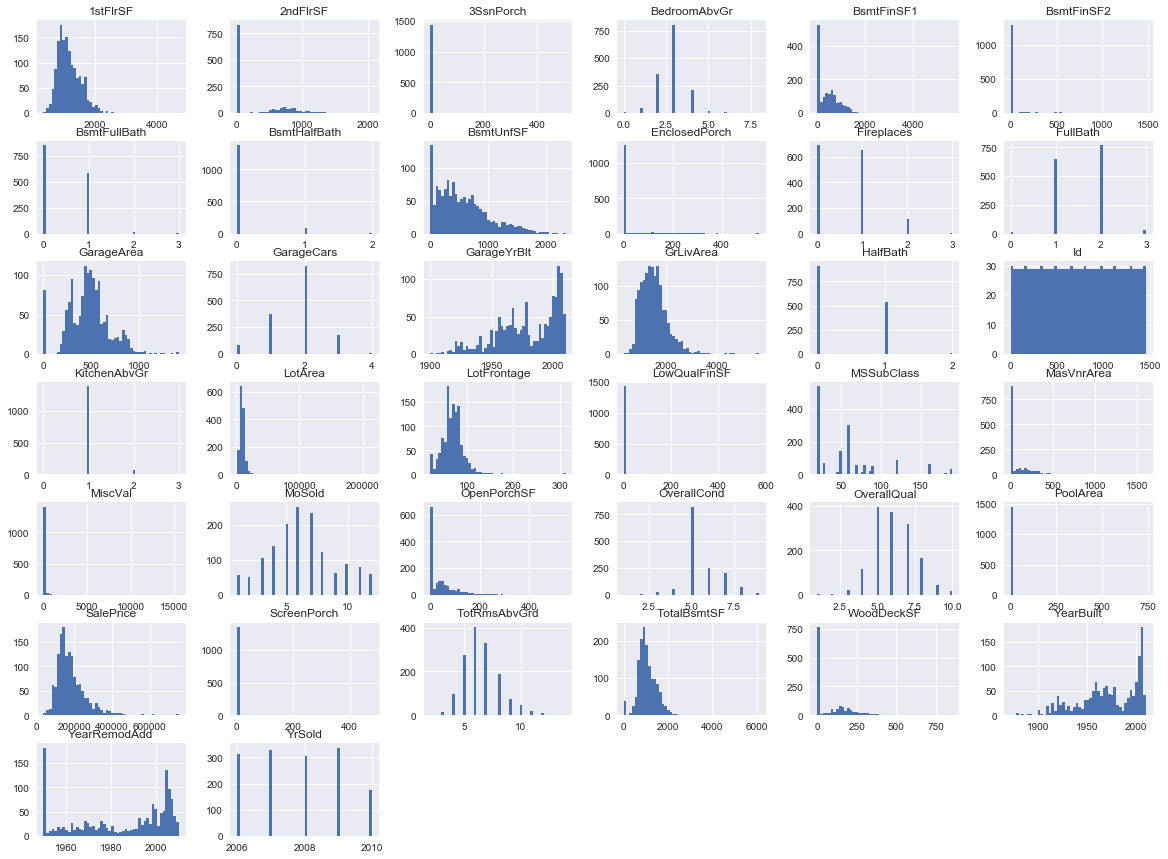

In [4]:
training_set.hist(bins = 50, figsize = (20, 15));

In [5]:
corr_matrix = training_set.corr()
corr_matrix['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

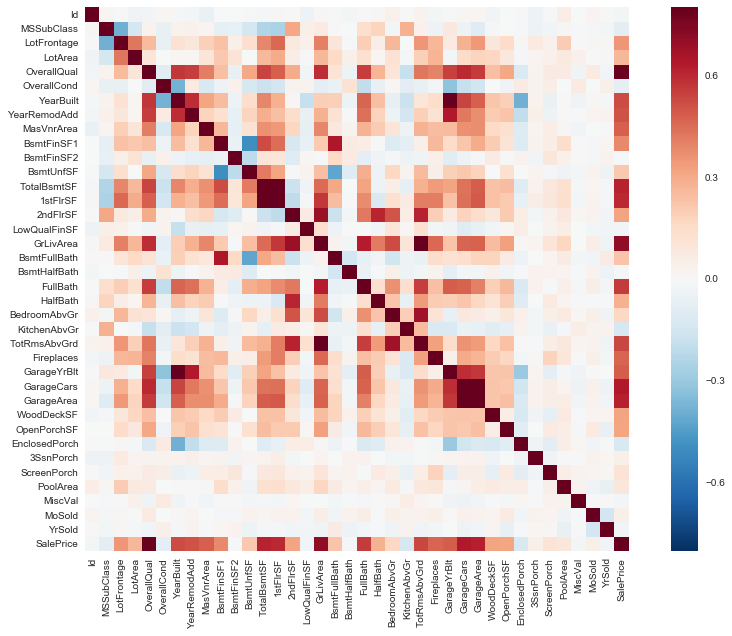

In [6]:
plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, vmax=.8, square=True)

Strong correlation between:
   - GarageYrBlt and YearBuilt
   - 1stFlrSF and TotalBsmtSF
   - TotRmsAbvGrd and GrLivArea
   - GarageArea and GarageCars

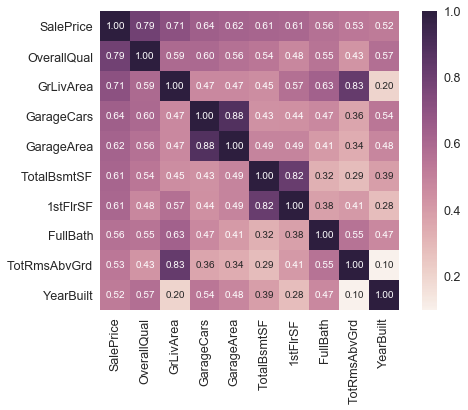

In [7]:
k = 10 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(training_set[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

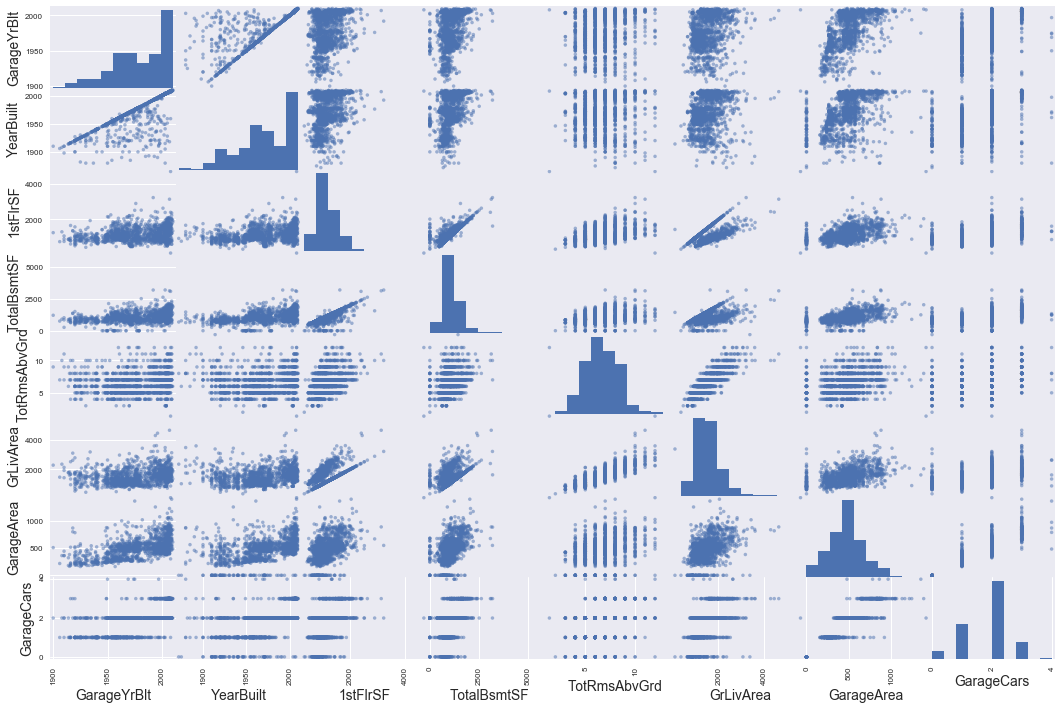

In [8]:
attrs = ['GarageYrBlt', 'YearBuilt', '1stFlrSF', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GrLivArea', 'GarageArea', 'GarageCars']
scatter_matrix(training_set[attrs], figsize = (18, 12));

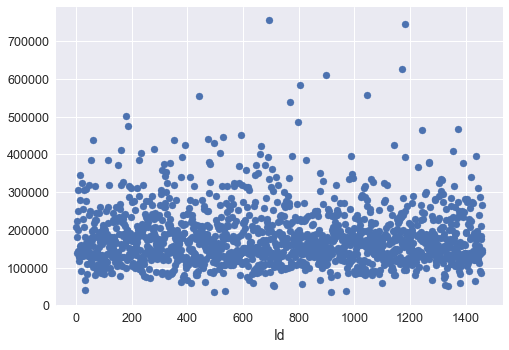

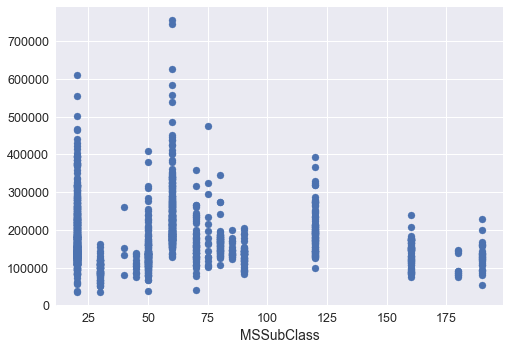

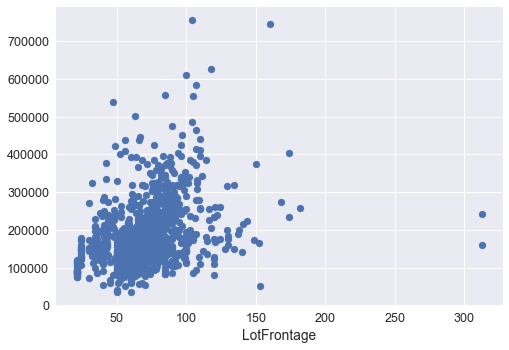

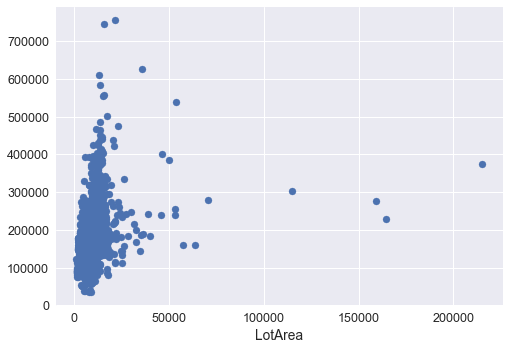

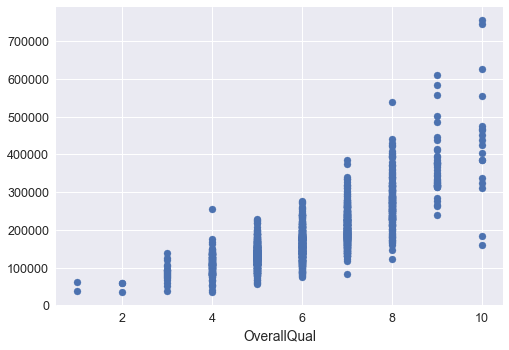

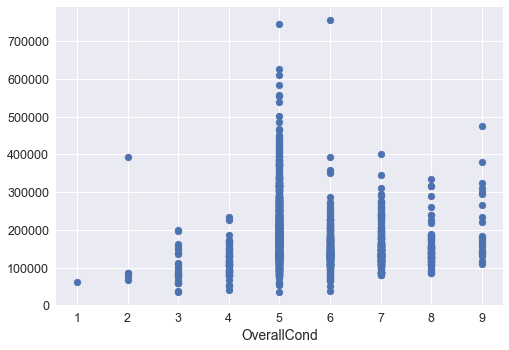

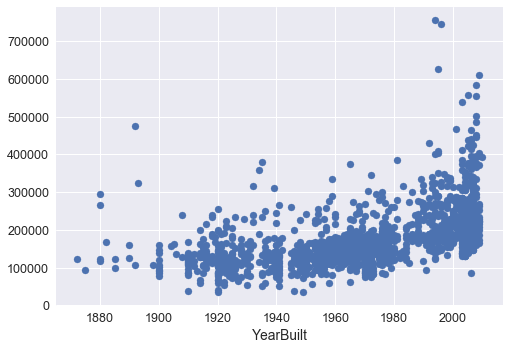

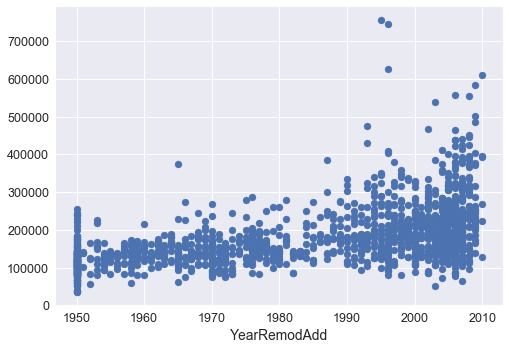

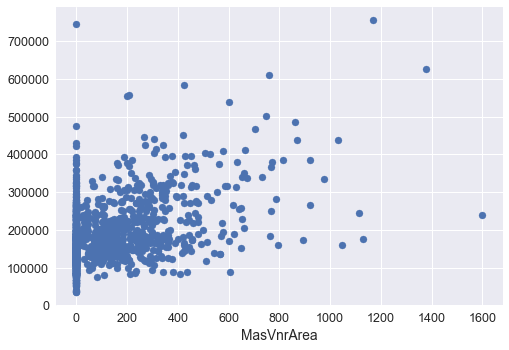

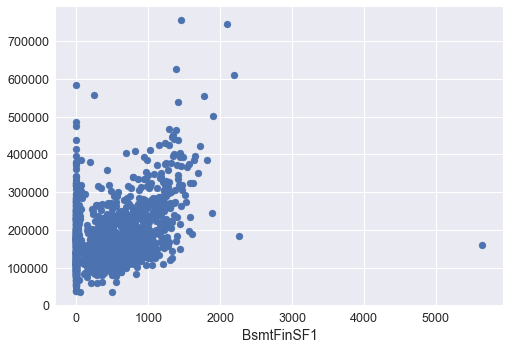

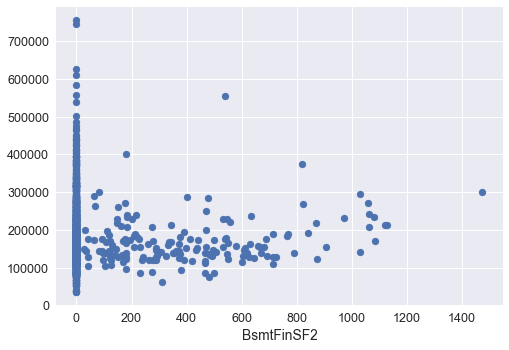

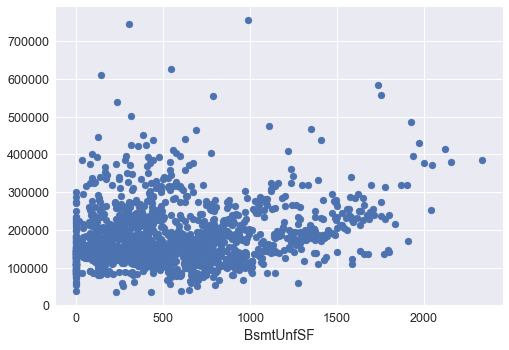

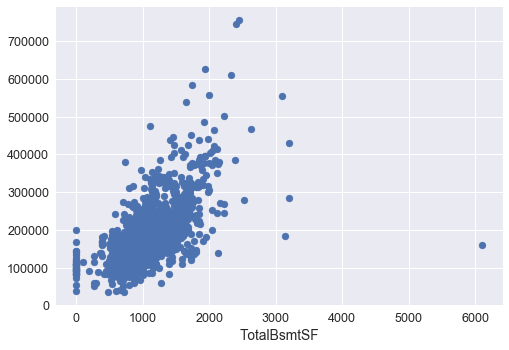

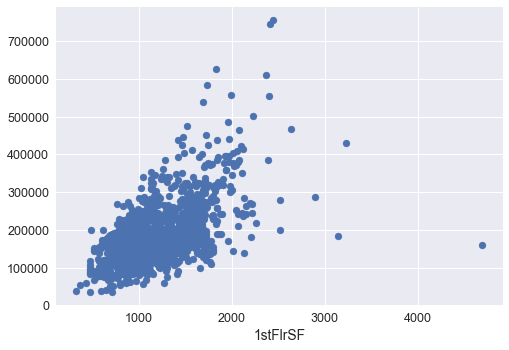

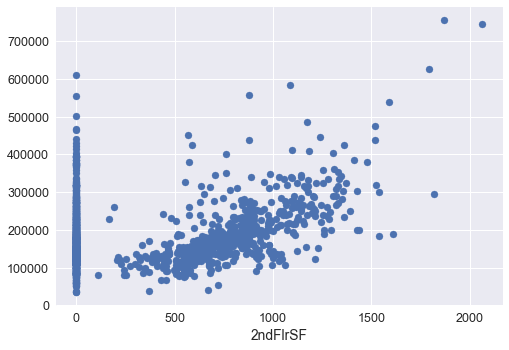

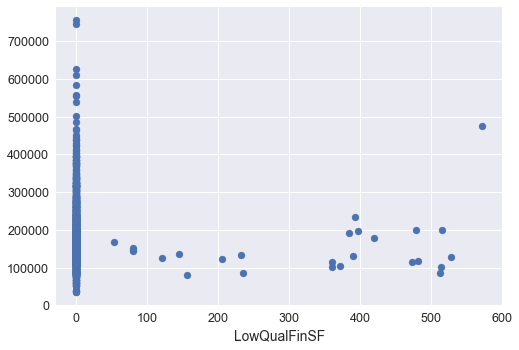

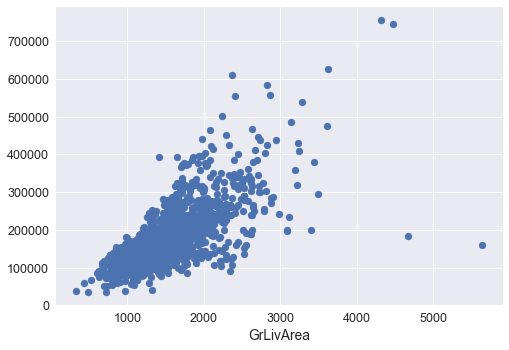

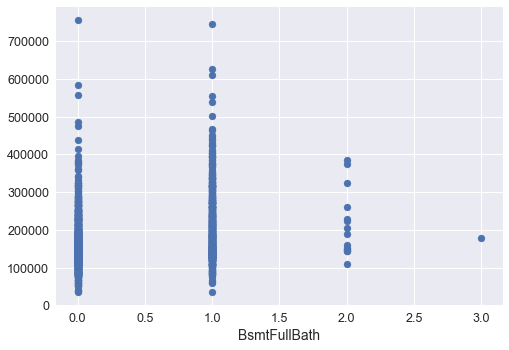

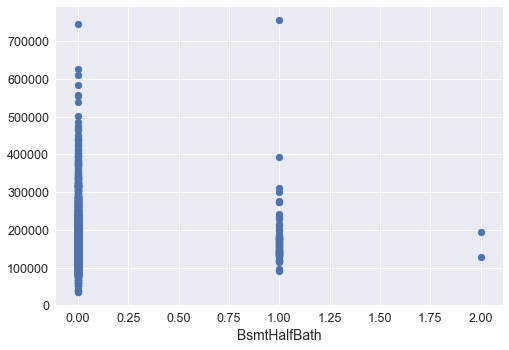

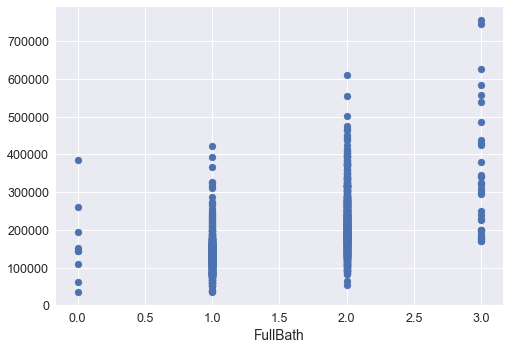

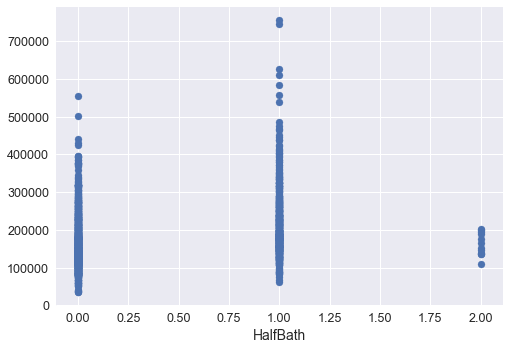

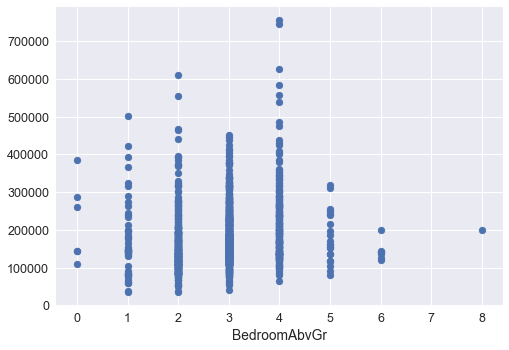

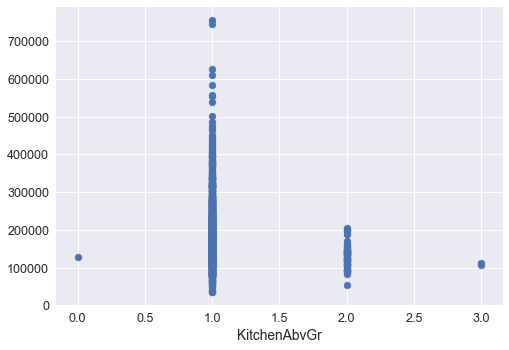

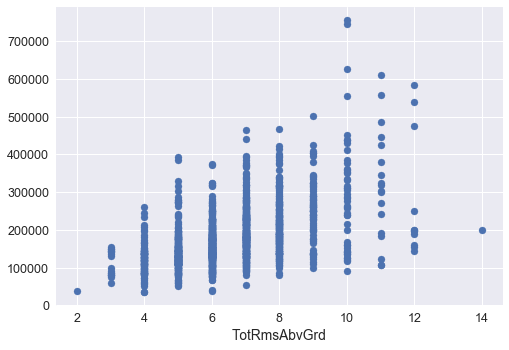

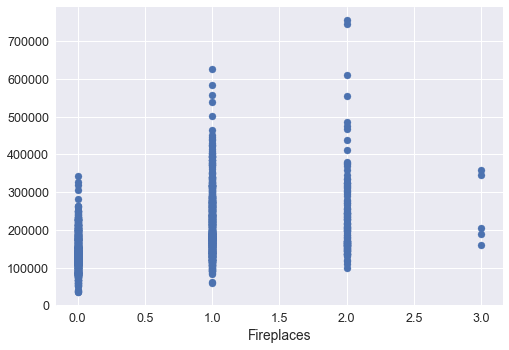

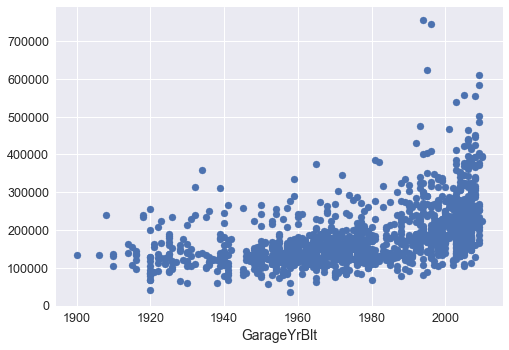

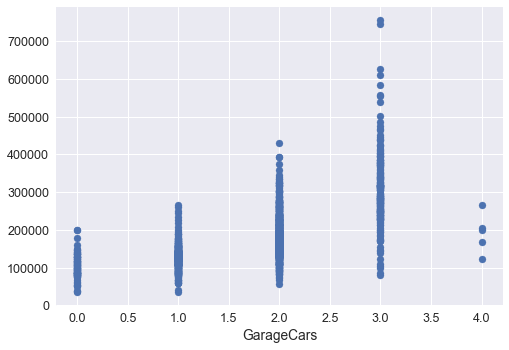

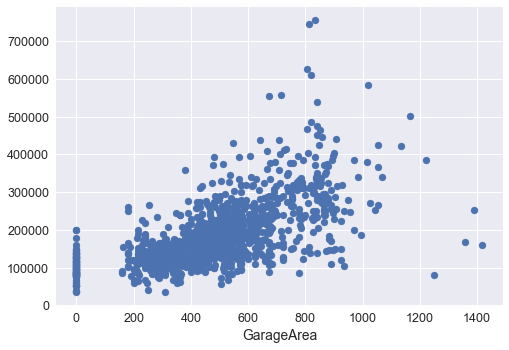

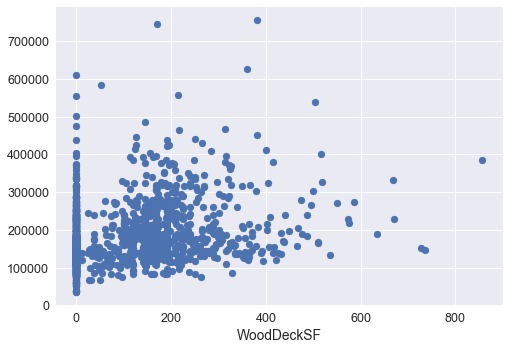

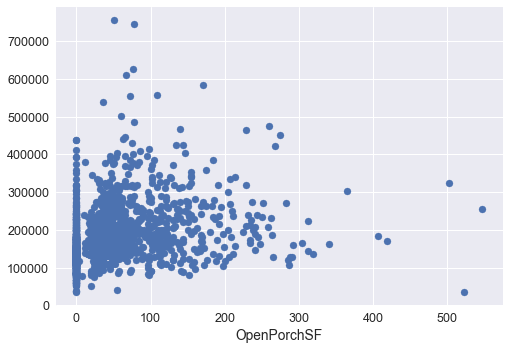

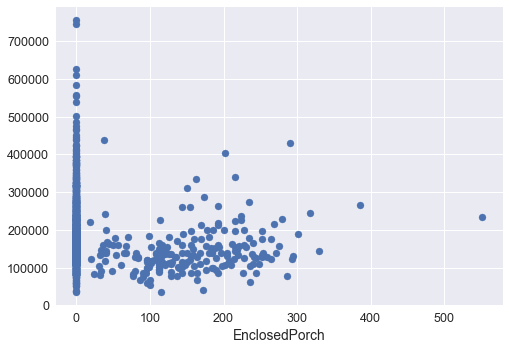

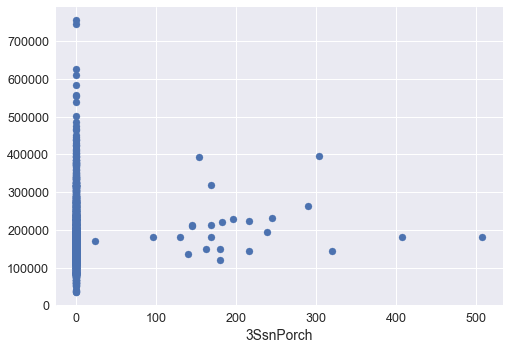

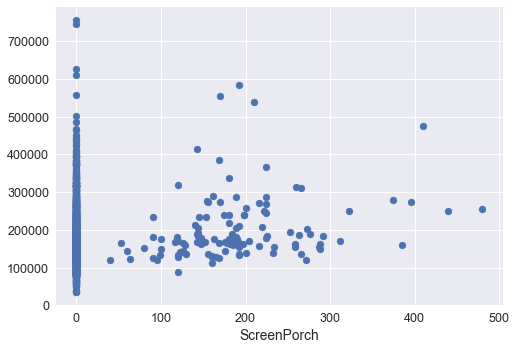

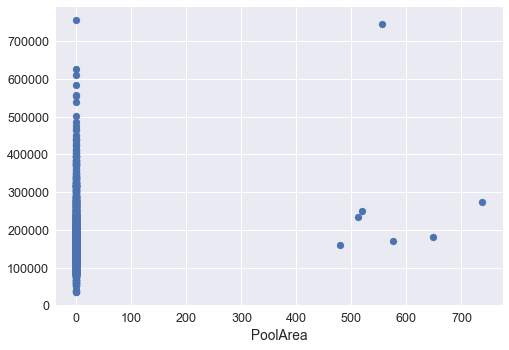

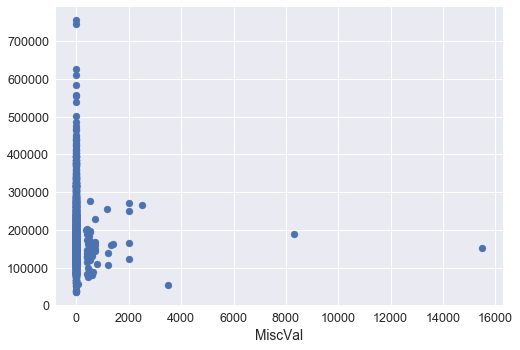

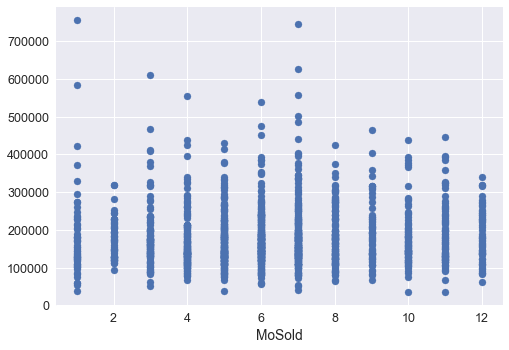

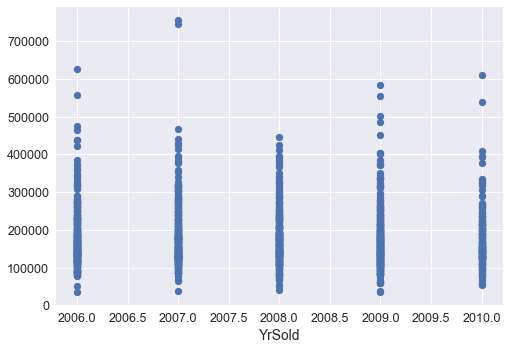

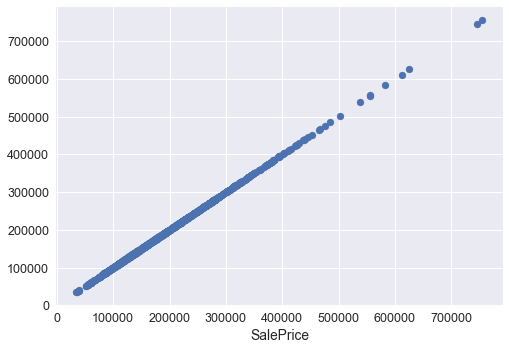

In [9]:
quantitative = corr_matrix.index

for name in quantitative:
    
    plt.scatter(training_set[name], training_set['SalePrice'])
    plt.xlabel(name)
    plt.show()

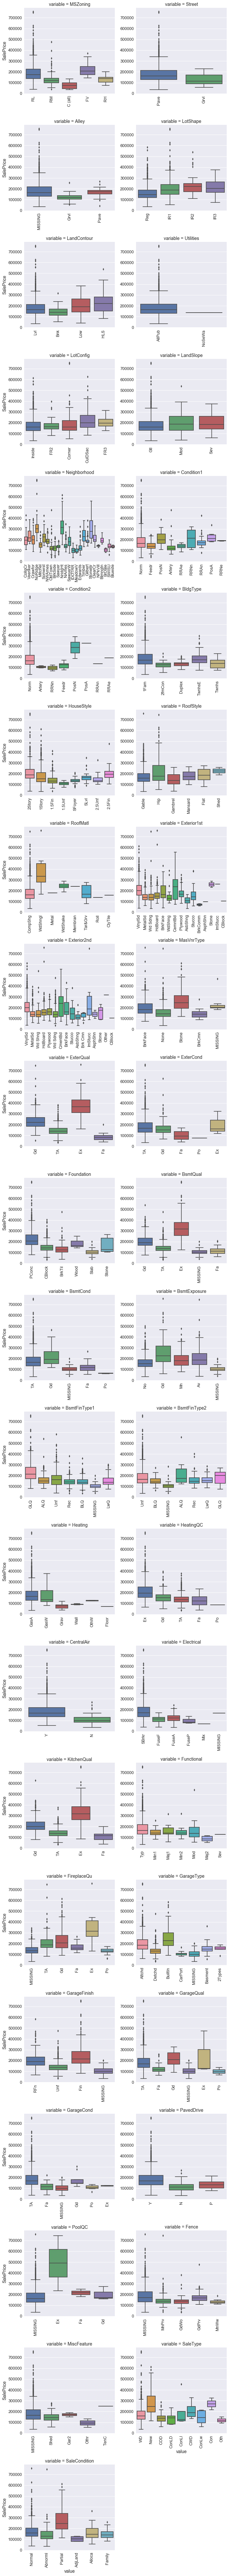

In [10]:
qualitative = training_set.select_dtypes(include = ['object'])
qualitative = qualitative.columns

for c in qualitative:
    training_set[c] = training_set[c].astype('category')
    if training_set[c].isnull().any():
        training_set[c] = training_set[c].cat.add_categories(['MISSING'])
        training_set[c] = training_set[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(training_set, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

# Data transformation

In [11]:
# Load the data
training_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

train = training_set.copy()
test = test_set.copy()

y = train['SalePrice']
X_train = train.drop(['SalePrice'], axis = 1)

print(X_train.shape, test.shape)

(1460, 80) (1459, 80)


In [12]:
# Train and test sets together for transformation
X_all = X_train.append(test)

# Transforming MSSubClass to categorical feature
X_all['MSSubClass'] = X_all['MSSubClass'].apply(str)
X_all.shape

(2919, 80)

### Log transformation for linear models

In [13]:
X_all_log = X_all.copy()
y_log = y.copy()

# transformed y
y_log = np.log1p(y_log)

numeric_features = X_all_log.dtypes[X_all_log.dtypes != "object"].index

# a set of skewed features
skewed_features = X_all_log[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

# transform skewed features
X_all_log[skewed_features] = np.log1p(X_all_log[skewed_features])
print(X_all_log.shape, y_log.shape)

(2919, 80) (1460,)


### Handling categorical values

In [14]:
X_all = pd.get_dummies(X_all)
X_all_log = pd.get_dummies(X_all_log)

### Features with the least importance

In [15]:
# drop columns
drop_list = ['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea', 'Id','Condition2_RRNn', 'Condition2_RRAn',
             'Condition2_RRAe', 'Condition2_PosA', 'Condition2_Feedr', 'Condition2_Artery',
             'Utilities_NoSeWa', 'Utilities_AllPub', 'SaleType_Oth', 'SaleType_ConLw', 'SaleType_ConLI', 'SaleType_Con',
             'SaleType_CWD', 'SaleCondition_AdjLand', 'RoofStyle_Shed', 'RoofStyle_Mansard',
             'RoofStyle_Flat', 'RoofMatl_WdShake', 'RoofMatl_Roll', 'RoofMatl_Metal', 'RoofMatl_Membran',
             'PoolQC_Fa', 'PoolQC_Ex', 'PavedDrive_P', 'Neighborhood_SWISU', 'Neighborhood_NPkVill',
             'Neighborhood_BrDale', 'Neighborhood_Blueste', 'Neighborhood_Blmngtn', 'MiscFeature_TenC', 'MiscFeature_Shed',
             'MiscFeature_Othr', 'MiscFeature_Gar2', 'MSSubClass_75', 'MSSubClass_45', 'MSSubClass_40',
             'MSSubClass_180', 'MSSubClass_150', 'LotShape_Reg', 'LotShape_IR3',
             'LandSlope_Sev', 'LandSlope_Gtl', 'KitchenQual_Fa', 'HouseStyle_SFoyer', 'HouseStyle_1.5Unf', 'Heating_Wall',
             'Heating_Floor', 'HeatingQC_Po', 'HeatingQC_Fa', 'GarageType_Basment',
             'GarageQual_Po', 'GarageCond_Po', 'GarageCond_Gd', 'GarageCond_Ex', 'Functional_Min2',
             'Functional_Min1', 'Foundation_Wood', 'Foundation_Stone', 'Foundation_Slab', 'Foundation_CBlock',
             'Exterior2nd_Stone', 'Exterior2nd_Plywood', 'Exterior2nd_ImStucc', 'Exterior2nd_CBlock',
             'Exterior2nd_BrkFace', 'Exterior2nd_Brk Cmn', 'Exterior1st_WdShing', 'Exterior1st_Stucco', 'Exterior1st_Stone',
             'Exterior1st_ImStucc', 'Exterior1st_CBlock', 'Exterior1st_BrkComm', 'Exterior1st_AsphShn', 'ExterQual_Fa',
             'ExterCond_Po', 'Electrical_Mix', 'Electrical_FuseP', 'Electrical_FuseF', 'Condition2_RRNn', 'Condition2_RRAn',
             'Condition2_RRAe', 'Condition2_PosA', 'Condition2_Feedr', 'Condition2_Artery', 'Condition1_RRNn',
             'Condition1_RRNe', 'Condition1_PosA', 'Condition1_Feedr', 'BsmtFinType2_Unf', 'BsmtFinType2_Rec',
             'BsmtFinType2_GLQ', 'BsmtExposure_Mn', 'BsmtCond_Po', 'BldgType_TwnhsE',
             'BldgType_Twnhs', 'BldgType_2fmCon', 'Alley_Grvl', 'SaleType_ConLD', 'MSSubClass_85', 'MSSubClass_190',
             'LandContour_Low', 'HouseStyle_2.5Unf', 'Condition1_RRAn', 'Street_Pave', 'RoofStyle_Hip', 'RoofMatl_CompShg',
             'PoolQC_Gd', 'MasVnrType_None', 'MSSubClass_120', 'HeatingQC_TA', 'GarageFinish_RFn', 'GarageCond_TA',
             'FireplaceQu_TA', 'Exterior2nd_MetalSd', 'Exterior2nd_HdBoard', 'Exterior2nd_CmentBd', 'Exterior2nd_AsphShn',
             'Exterior1st_CemntBd', 'ExterCond_Gd', 'ExterCond_Ex', 'BsmtFinType2_LwQ', 'BsmtExposure_Av']
X_all = X_all.drop(drop_list, axis = 1)
X_all_log = X_all_log.drop(drop_list, axis = 1)

features = X_all.columns

X_train = X_all[:X_train.shape[0]]
X_test = X_all[X_train.shape[0]:]
X_train_log = X_all_log[:X_train.shape[0]]
X_test_log = X_all_log[X_train.shape[0]:]
print(X_train.shape, X_test.shape)
print(X_train_log.shape, X_test_log.shape)

(1460, 183) (1459, 183)
(1460, 183) (1459, 183)


In [16]:
features

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'Fence_MnPrv', 'Fence_MnWw', 'SaleType_COD', 'SaleType_New',
       'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=183)

### Pipeline to transform data

In [17]:
class SelectorData(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.features].values

In [18]:
num_features = np.setdiff1d(numeric_features, ['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea', 'Id', 'BsmtFinSF2', 
             'LowQualFinSF', 'BsmtHalfBath', 'MiscVal'], assume_unique = True)
cat_features = np.setdiff1d(features, numeric_features, assume_unique = True)

In [19]:
all_features = np.append(num_features, cat_features)
all_features

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold', 'MSSubClass_160',
       'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_50', 'MSSubClass_60',
       'MSSubClass_70', 'MSSubClass_80', 'MSSubClass_90',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Alley_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LandContour_Bnk', 'LandContour_HLS',
       'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Mod', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighb

In [20]:
num_pipeline = Pipeline([
    ('selector', SelectorData(num_features)),
    ('imputer', Imputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', SelectorData(cat_features)),
    ('imputer', Imputer(strategy = 'median'))
])

num_log_pipeline = Pipeline([
    ('selector', SelectorData(num_features)),
    ('imputer', Imputer(strategy = 'median'))
])

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

full_pipeline_log = FeatureUnion(transformer_list = [
    ('num_pipeline', num_log_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [21]:
X_prepared = full_pipeline.fit_transform(X_train)
test_prepared = full_pipeline.transform(X_test)
print(X_prepared.shape, test_prepared.shape)
X_prepared

(1460, 179) (1459, 179)


array([[-0.22087509, -0.20714171,  0.65147924, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.46031974, -0.09188637, -0.07183611, ...,  0.        ,
         1.        ,  0.        ],
       [-0.08463612,  0.07347998,  0.65147924, ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [-0.1754621 , -0.14781027,  0.65147924, ...,  0.        ,
         1.        ,  0.        ],
       [-0.08463612, -0.08016039, -0.79515147, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.23325479, -0.05811155, -0.79515147, ...,  0.        ,
         1.        ,  0.        ]])

In [22]:
X_prepared_log = full_pipeline_log.fit_transform(X_train_log)
test_prepared_log = full_pipeline_log.transform(X_test_log)
print(X_prepared_log.shape, test_prepared_log.shape)
X_prepared_log

(1460, 179) (1459, 179)


array([[ 4.18965474,  9.04204006,  7.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 4.39444915,  9.16962254,  6.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 4.2341065 ,  9.32821229,  7.        , ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [ 4.20469262,  9.10974626,  7.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 4.2341065 ,  9.18173511,  5.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 4.33073334,  9.20412107,  5.        , ...,  0.        ,
         1.        ,  0.        ]])

# Modeling

### Lasso

In [23]:
lasso = Lasso(max_iter = 10000)
param_grid = {"alpha": [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.008, 0.009, 0.001, 0.003]}
grid_search_lasso_log = GridSearchCV(lasso, cv = 10, param_grid = param_grid, scoring = 'neg_mean_squared_error')
grid_search_lasso_log.fit(X_prepared_log, y_log)
grid_search_lasso_log.best_estimator_

Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
cvres = grid_search_lasso_log.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.124000241857 {'alpha': 0.0001}
0.122983141993 {'alpha': 0.0002}
0.122595278505 {'alpha': 0.0003}
0.122601780301 {'alpha': 0.0004}
0.122862959025 {'alpha': 0.0005}
0.123099038658 {'alpha': 0.0006}
0.123302833219 {'alpha': 0.0007}
0.145186371469 {'alpha': 0.008}
0.146442740058 {'alpha': 0.009}
0.124758185563 {'alpha': 0.001}
0.13530604467 {'alpha': 0.003}


In [25]:
sig_features = pd.Series(grid_search_lasso_log.best_estimator_.coef_, index = all_features)
print(sig_features.sort_values().head(60))
print(sig_features.sort_values().tail(60))

RoofMatl_ClyTile        -1.031679
Condition2_PosN         -0.347723
MSZoning_C (all)        -0.330112
Functional_Maj2         -0.092702
KitchenAbvGr            -0.072457
Neighborhood_Edwards    -0.061214
Heating_Grav            -0.052125
Condition1_RRAe         -0.051748
SaleType_WD             -0.047395
GarageCond_Fa           -0.045546
SaleCondition_Abnorml   -0.043727
CentralAir_N            -0.039881
MSZoning_RM             -0.037459
MSSubClass_160          -0.036542
Neighborhood_Mitchel    -0.035804
SaleType_COD            -0.030225
LandContour_Bnk         -0.029495
Condition1_Artery       -0.024726
MasVnrType_BrkCmn       -0.023720
Neighborhood_NWAmes     -0.023248
Exterior1st_Wd Sdng     -0.021325
Fence_GdWo              -0.021311
LotConfig_FR2           -0.020093
MSSubClass_30           -0.018840
Foundation_BrkTil       -0.016106
Neighborhood_OldTown    -0.015468
BsmtFinType2_BLQ        -0.014564
Neighborhood_NAmes      -0.013463
SaleCondition_Family    -0.013302
MSSubClass_90 

### Elastic Net

In [27]:
elastic = ElasticNet(max_iter = 10000)
param_grid = {'alpha': [0.0008],
             'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
grid_search_elastic_log = GridSearchCV(elastic, cv = 10, param_grid = param_grid, scoring = 'neg_mean_squared_error')
grid_search_elastic_log.fit(X_prepared_log, y_log)
grid_search_elastic_log.best_estimator_

ElasticNet(alpha=0.0008, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
cvres = grid_search_elastic_log.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.122136635921 {'alpha': 0.0008, 'l1_ratio': 0.1}
0.121889877322 {'alpha': 0.0008, 'l1_ratio': 0.2}
0.121907853456 {'alpha': 0.0008, 'l1_ratio': 0.3}
0.1220718107 {'alpha': 0.0008, 'l1_ratio': 0.4}
0.122378529252 {'alpha': 0.0008, 'l1_ratio': 0.5}
0.122797490974 {'alpha': 0.0008, 'l1_ratio': 0.6}
0.123084451255 {'alpha': 0.0008, 'l1_ratio': 0.7}
0.123251989711 {'alpha': 0.0008, 'l1_ratio': 0.8}
0.123416200668 {'alpha': 0.0008, 'l1_ratio': 0.9}


In [29]:
sig_features = pd.Series(grid_search_elastic_log.best_estimator_.coef_, index = all_features)
print(sig_features.sort_values().head(60))
print(sig_features.sort_values().tail(60))

RoofMatl_ClyTile        -0.574978
MSZoning_C (all)        -0.302336
Condition2_PosN         -0.281210
Functional_Maj2         -0.123504
KitchenAbvGr            -0.088411
Neighborhood_Edwards    -0.078819
Heating_Grav            -0.076555
Condition1_RRAe         -0.063836
SaleType_WD             -0.056453
MSSubClass_160          -0.055550
GarageCond_Fa           -0.048523
Neighborhood_Mitchel    -0.047689
SaleCondition_Abnorml   -0.046854
SaleType_COD            -0.045110
Neighborhood_MeadowV    -0.042376
LandContour_Bnk         -0.039513
Neighborhood_OldTown    -0.037450
Neighborhood_NWAmes     -0.032961
GarageType_2Types       -0.031779
MasVnrType_BrkCmn       -0.031149
Exterior1st_Wd Sdng     -0.030432
Neighborhood_NAmes      -0.026797
Fence_GdWo              -0.026729
SaleCondition_Family    -0.026438
Condition1_Artery       -0.026128
LotConfig_FR2           -0.025446
CentralAir_N            -0.025071
MSSubClass_30           -0.024068
GarageQual_Fa           -0.023242
Neighborhood_I

### GradientBoostingRegressor

In [30]:
grad_boost = GradientBoostingRegressor()
param_grid = {'n_estimators': [900, 1000, 1100],
             'max_depth': [3],
             'min_samples_split': [7, 8, 9]}
grid_search_grad = GridSearchCV(grad_boost, cv = 10, param_grid = param_grid, scoring = 'neg_mean_squared_error')
grid_search_grad.fit(X_prepared, y)
grid_search_grad.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=7,
             min_weight_fraction_leaf=0.0, n_estimators=1100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [31]:
cvres = grid_search_grad.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

24820.1000838 {'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 900}
24721.4988732 {'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 1000}
24646.9922806 {'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 1100}
25223.555073 {'max_depth': 3, 'min_samples_split': 8, 'n_estimators': 900}
24686.03869 {'max_depth': 3, 'min_samples_split': 8, 'n_estimators': 1000}
24837.3024161 {'max_depth': 3, 'min_samples_split': 8, 'n_estimators': 1100}
25433.8139445 {'max_depth': 3, 'min_samples_split': 9, 'n_estimators': 900}
25021.6157238 {'max_depth': 3, 'min_samples_split': 9, 'n_estimators': 1000}
25312.0523408 {'max_depth': 3, 'min_samples_split': 9, 'n_estimators': 1100}


In [32]:
feature_importance = grid_search_grad.best_estimator_.feature_importances_
sorted(zip(feature_importance, all_features), reverse = True)

[(0.076746270994585544, 'LotArea'),
 (0.07091174655422626, 'BsmtUnfSF'),
 (0.067893567715845496, 'GrLivArea'),
 (0.050202093144316028, '1stFlrSF'),
 (0.048969747288131388, 'BsmtFinSF1'),
 (0.039661396360640547, 'YearBuilt'),
 (0.033850018815366721, 'WoodDeckSF'),
 (0.033118488505775603, 'LotFrontage'),
 (0.027985722247005965, 'OpenPorchSF'),
 (0.027077718991049431, 'MasVnrArea'),
 (0.026765410797836935, 'OverallQual'),
 (0.025689545845521897, 'YearRemodAdd'),
 (0.024490868952224677, 'MoSold'),
 (0.021030970355005764, '2ndFlrSF'),
 (0.019544118784871528, 'OverallCond'),
 (0.014873118954938418, 'EnclosedPorch'),
 (0.014196805992777509, 'ScreenPorch'),
 (0.01413087948981734, 'BedroomAbvGr'),
 (0.011017267616723328, 'GarageCars'),
 (0.010567628414033326, 'YrSold'),
 (0.0072250608061799242, 'FireplaceQu_Fa'),
 (0.0071395849274915437, 'SaleCondition_Family'),
 (0.0065858462630925567, 'PoolArea'),
 (0.0064387314341494434, 'BsmtFullBath'),
 (0.006361219878142991, 'Neighborhood_Edwards'),
 (0.0

### XGB

In [33]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev2\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

xgb = xgb.XGBRegressor()
param_grid = {'max_depth': [2, 3, 4],
             'n_estimators': [1100, 1200, 1300],
             'booster': ['gbtree', 'gblinear']}
grid_search_xgb = GridSearchCV(xgb, cv = 10, param_grid = param_grid, scoring = 'neg_mean_squared_error')
grid_search_xgb.fit(X_prepared, y)
grid_search_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=1300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
cvres = grid_search_xgb.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

# Test and submission

### Elastic net - score 0.12081

In [ ]:
pred_test_elastic = grid_search_elastic_log.best_estimator_.predict(test_prepared_log)

In [ ]:
result = np.expm1(pred_test_elastic)
submission_df = pd.DataFrame({ 'Id': test['Id'],
                            'SalePrice': result})
submission_df.to_csv("Submission_elastic.csv", index=False)

### GradientBoosting - score 0.13498

In [ ]:
pred_test_grad = grid_search_grad.best_estimator_.predict(test_prepared)

In [ ]:
submission_df = pd.DataFrame({ 'Id': test['Id'],
                            'SalePrice': pred_test_grad})
submission_df.to_csv("Submission_grad.csv", index=False)